# Aligning to ambiguous references in remapping pipelines
## Filling references versus relevant parameter adjustment
### April 16th, 2025

The purpose of this notebook will be to explore the effect of various flags that can be supplied to the bowtie2 read mapper in remapping pipelines and their relevance to the problem of alignment to a reference with ambiguous bases. Additionally, an alternative strategy known as filling in a reference will be described and compared. A complete influeza A genome with annotations has been crafted based on `A/sanderling/MA/22HP00159/2022`, containing complete segments with Uni12 and Uni13 and is used henceforth. Some questions that arose were:
- What is "ambig creep" in remapping pipelines?
- Are there any command line arguments to various tools to deal with ambiguities that can avoid it?
- What is the filling strategy to deal with the ambig creep problem?
- What effect does global instead of local alignment have?
- How do the various strategies and options compare?

Interested readers can refer to Bowtie2's documentation on [end-to-end vs. local alignment](https://bowtie-bio.sourceforge.net/bowtie2/manual.shtml#end-to-end-alignment-versus-local-alignment) and [ambiguous characters](https://bowtie-bio.sourceforge.net/bowtie2/manual.shtml#ambiguous-characters). Note that end-to-end/global alignment is the default.

## Ambiguity creep in remapping pipelines

Without care, ambiguous bases in initial consensus calls that are then used as reference in a later step can proliferate. This can be clearly illustrated in the `mp` segment of `be_w3` for replicate 2. Everything in this notebook was ran with [this commit](https://github.com/moncla-lab/illumina-pipeline/commit/9cdd1c6b479db9c3ba9607b9e2f981549d4fa328) of the pipeline, whose default configuration is currently the following:
- local alignment
- default penalty (1) for aligning to an ambiguous base with bowtie2 (`--np` flag)
- default amount (15 %) of ambiguous bases allowed in a read to keep (`--n-ceil` flag)
- filling in the reference, a strategy to deal with ambig creep (more on this later)

First let's illustrate the motivation to fill by disabling it, calling this the "no-fill" strategy. We'll show the reference (`ml`), as well as the `initial`, `remapping`, and `reremapping` consensus calls.

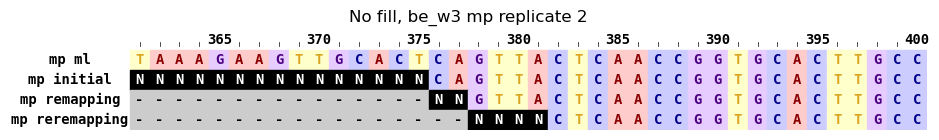

In [2]:
view_msa(
    "./fasta/be_w3-mp-2_current_aligned.fasta",
    start=360,
    stop=400,
    title="No fill, be_w3 mp replicate 2",
)

We see that in our initial call, a bunch of N's are called due to a lack of coverage. This problem <i>worsens</i> as more remapping steps are applied. This is due to bowtie2 having difficulty aligning to regions with ambiguities. By default, it applies a penalty for alignments to ambiguous bases, thus refusing to align additional reads at the boundary of a region that is already struggling with sufficient coverage to be called.

This can be fixed by <b>filling in the reference</b>. Wherever an ambiguous base is called, we can fill in the original reference so that the aligners have something to map to. It is conceptually similar to calling a sample consensus from replicate consensus sequences as in the previous notebook, but not identical. However, this step is unintuitive as filling in usually has negative connotations for downstream analyses and requires consideration of handling indels. Let's see how this strategy performs, which we'll call "with-fill."

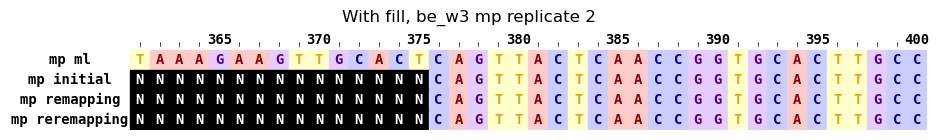

In [3]:
view_msa(
    "./fasta/be_w3-mp-2_with-fill_aligned.fasta",
    start=360,
    stop=400,
    title="With fill, be_w3 mp replicate 2",
)

We see that this alleviates the problem, and that there are no bases lost at each step. The impact is not too dramatic here, only saving 6 lost bases, but it shows how delicate this problem is, and that signal can be lost in bioinformatic noise.

## Adjust ambiguous penalty parameters

What if we turn off the penalty for ambiguous bases and allow more read length, say 50%, to map to ambiguous bases? We'll call this "no penalty." Below we'll see that the problem persists despite this effort.

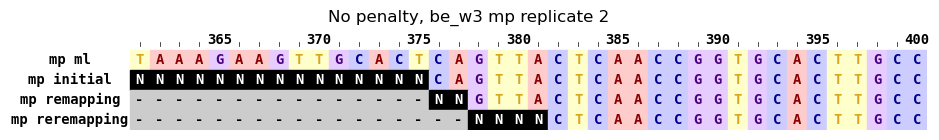

In [4]:
view_msa(
    "./fasta/be_w3-mp-2_local-nopenalty_aligned.fasta",
    start=360,
    stop=400,
    title="No penalty, be_w3 mp replicate 2",
)

It is fair to ask, why 50% and not as high as possible? The ability to align 100% of a read to an ambiguous region seems rather dubious. One would expect with 50% and local alignment that they could find some instances of where this strategy is effective if they existed. Unfortunately, this was not the case with this exploration.

## Global option

We were also interested in the "global" flag, which appears to struggle even more with this problem without fill, presumably due to the requirement that it tries to align the entire read. Here is the same region:

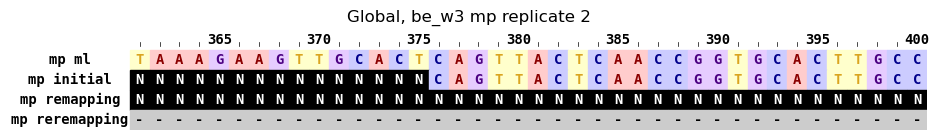

In [5]:
view_msa(
    "./fasta/be_w3-mp-2_global_aligned.fasta",
    start=360,
    stop=400,
    title="Global, be_w3 mp replicate 2",
)

This is not the only problem with the global approach. It also has a tendency to add bases that do not appear in the completed reference, such as below (note the extra base added to the Uni12 `AGCAAAAGCAGG` motif). As such, this approach will be discarded for the remainder of the notebook.

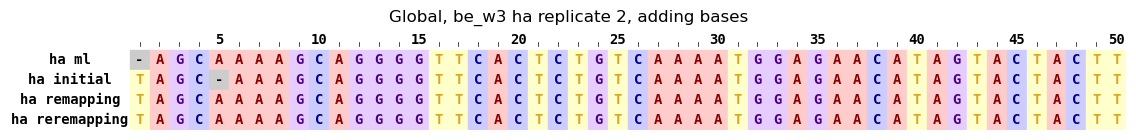

In [6]:
view_msa(
    "./fasta/be_w3-ha-2_global_aligned.fasta",
    start=0,
    stop=50,
    title="Global, be_w3 ha replicate 2, adding bases",
)

For clarity, the strategy of the pipeline at present is "with-fill." The experimentation of deviations from the strategy were implemented in a slightly hacky way, with the following edits made to the repo but not committed:

For no fill, we simply copy the reference over in `fill_consensus`:

```
 def fill_consensus(consensus_fasta, reference_fasta, filled_output):
+    shutil.copy(consensus_fasta, filled_output)
+    return
     consensus_dict = SeqIO.to_dict(SeqIO.parse(consensus_fasta, "fasta"))
     reference_dict = SeqIO.to_dict(SeqIO.parse(reference_fasta, "fasta"))
     output_records = []
```

For no penalty, we keep the above and additionally add the following flags to the `mapping` rule:

```
             bowtie2 --local --very-sensitive-local -x {params} \
                 -1 {input.forward_paired} -2 {input.reverse_paired} \
                 -U {input.forward_unpaired},{input.reverse_unpaired} \
+                --np 0 \
+                --n-ceil L,0,.5 \
                 -S {output.sam} \
                 > {output.stdout} 2> {output.stderr}
```

And for global we instead add these flags for the `mapping` rule:

```
-            bowtie2 --local --very-sensitive-local -x {params} \
+            bowtie2 --very-sensitive -x {params} \
                 -1 {input.forward_paired} -2 {input.reverse_paired} \
                 -U {input.forward_unpaired},{input.reverse_unpaired} \
                 -S {output.sam} \
                 > {output.stdout} 2> {output.stderr}
```

The code to view MSAs in this notebook, as well as some helpful bash to produce the MSAs we view, is at the end. Let's look at a few more samples.

Note that there are other cases where the with fill strategy outperforms the no penalty strategy in this same sample:

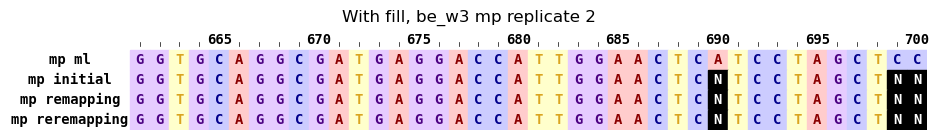

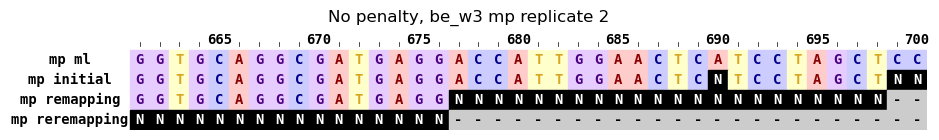

In [7]:
start = 660
stop = 700
view_msa(
    "./fasta/be_w3-mp-2_with-fill_aligned.fasta",
    start=start,
    stop=stop,
    title="With fill, be_w3 mp replicate 2",
)
view_msa(
    "./fasta/be_w3-mp-2_local-nopenalty_aligned.fasta",
    start=start,
    stop=stop,
    title="No penalty, be_w3 mp replicate 2",
)

Fortunately, this problem is not entirely pervasive. Some regions just entirely drop out, like `cl_c2` `pb2` replicate `1`, and both with fill and no penalty approaches perform comparably here:

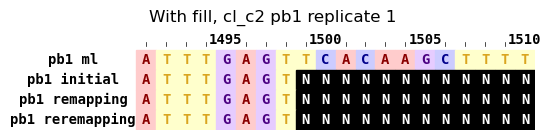

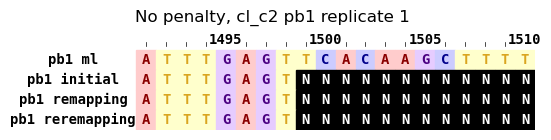

In [8]:
start = 1490
stop = 1510
sample = 'cl_c2'
segment = 'pb1'
replicate = 1
view_msa(
    f"./fasta/{sample}-{segment}-{replicate}_with-fill_aligned.fasta",
    start=start,
    stop=stop,
    title=f"With fill, {sample} {segment} replicate {replicate}",
)
view_msa(
    f"./fasta/{sample}-{segment}-{replicate}_local-nopenalty_aligned.fasta",
    start=start,
    stop=stop,
    title=f"No penalty, {sample} {segment} replicate {replicate}",
)

Unfortunately, some samples present even more extreme versions of the undesirable behavior like `ms_w2` `pa` replicate `1`. This even manages to cast doubt on a second remapping with refill being a robust strategy. Observe below that there are inconsistencies in the initial and second remapping consensus calls.

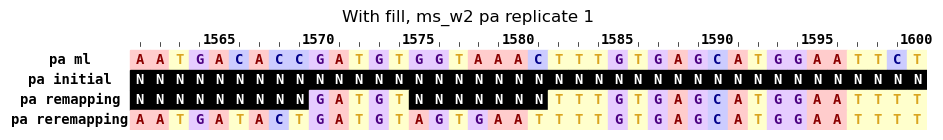

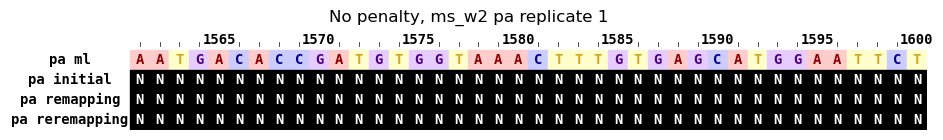

In [9]:
start = 1560
stop = 1600
sample = 'ms_w2'
segment = 'pa'
replicate = 1
view_msa(
    f"./fasta/{sample}-{segment}-{replicate}_with-fill_aligned.fasta",
    start=start,
    stop=stop,
    title=f"With fill, {sample} {segment} replicate {replicate}",
)
view_msa(
    f"./fasta/{sample}-{segment}-{replicate}_local-nopenalty_aligned.fasta",
    start=start,
    stop=stop,
    title=f"No penalty, {sample} {segment} replicate {replicate}",
)

This region <i>drops out entirely</i> with the no penalty strategy, and only <i>slowly</i> fills in, even with a second remapping. It begs the question of whether two remappings is even enough, given the dramatic difference in ambiguities called between the first and second remappings. This stretches on for at least 200 bps; an additional remapping could reveal that more of this highly diverged PA would fill in.

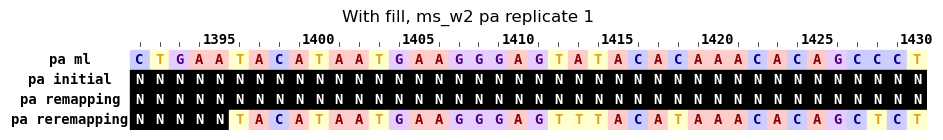

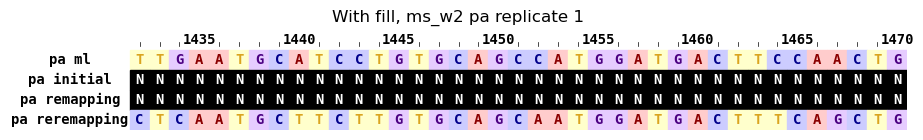

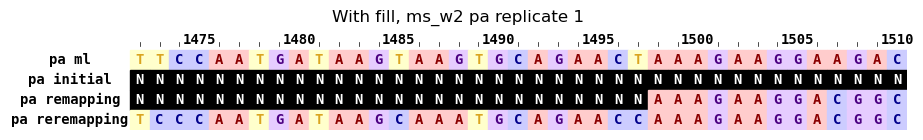

In [10]:
start = 1390
stop = 1430
sample = 'ms_w2'
segment = 'pa'
replicate = 1
view_msa(
    f"./fasta/{sample}-{segment}-{replicate}_with-fill_aligned.fasta",
    start=start,
    stop=stop,
    title=f"With fill, {sample} {segment} replicate {replicate}",
)
start = 1431
stop = 1470
sample = 'ms_w2'
segment = 'pa'
replicate = 1
view_msa(
    f"./fasta/{sample}-{segment}-{replicate}_with-fill_aligned.fasta",
    start=start,
    stop=stop,
    title=f"With fill, {sample} {segment} replicate {replicate}",
)
start = 1471
stop = 1510
sample = 'ms_w2'
segment = 'pa'
replicate = 1
view_msa(
    f"./fasta/{sample}-{segment}-{replicate}_with-fill_aligned.fasta",
    start=start,
    stop=stop,
    title=f"With fill, {sample} {segment} replicate {replicate}",
)

Here is a snapshot of the start of this highly divergent region in Aliview:
<img src="images/002-highly-divergent.png" width="1140"/>

## Summary

The problem of ambig creep has been described. The most effective strategy tried thus far for dealing with this appears to be filling in the reference with two remappings. Unfortuantely, even this may not even be completely robust.

## Implementation details

This was implemented by running the repository at the present commit on our entire PA bird dataset. A glance at the coverage report revealed samples with dropout that could serve to explore the questions posed. The repository was then cloned three more times with the various edits made above to explore the different options.

Here is some bash that was useful for generating the MSAs from a full run of each version of the pipeline:

```
# user parameters
sample=be_w3
segment=mp
replicate=2
combo="local-nopenalty"

# script variables
fasta=fasta/$sample-$segment-${replicate}_${combo}_unaligned.fasta
aligned=fasta/$sample-$segment-${replicate}_${combo}_aligned.fasta

# visualization pipeline
seqkit grep -p $segment $combo/data/reference/sequences.fasta > $fasta
cat $combo/data/$sample/replicate-$replicate/{initial,remapping,reremapping}/segments/$segment/consensus.fasta >> $fasta
mafft $fasta > $aligned
open $aligned

echo "To make this file: "
echo "snakemake -j 1 data/$sample/replicate-$replicate/reremapping/segments/$segment/consensus.fasta"
```

And here is some (LLM generated) code to make MSAs in a Jupyter notebook:

In [1]:
from Bio import SeqIO
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def view_msa(
    fasta_path, 
    start=0, 
    stop=None, 
    title='', 
    label_cutoff=20, 
    font_size=10, 
    base_size=30,        # base cell: base_size x base_size pixels exactly 
    max_label_width_px=100  # maximum allowed label width in pixels
):
    # Load sequences and truncate descriptions.
    records = list(SeqIO.parse(fasta_path, "fasta"))
    if not records:
        raise ValueError("No sequences found in the file.")
    
    seqs = [str(r.seq).upper() for r in records]
    labels = [r.description[:label_cutoff] for r in records]
    
    aln_len = len(seqs[0])
    stop = stop if stop is not None else aln_len
    # Slice the alignment.
    view = [s[start:stop] for s in seqs]
    view_width = stop - start   # Number of bases (columns) in the alignment view.
    num_rows = len(view)        # Number of sequences (rows).

    # --- Compute Left Margin for Labels ---
    # Approximate each character width as font_size * 0.6 (in pixels).
    # Using label_cutoff as the maximum characters to show,
    # then cap the computed width by max_label_width_px.
    computed_label_width = max([len(label) for label in labels]) * font_size + 40
    left_margin_pixels = computed_label_width #min(computed_label_width, max_label_width_px)
    # Convert left margin from pixels to data units. One data unit equals base_size pixels.
    label_margin_units = left_margin_pixels / base_size

    # --- Compute Figure Size in Pixels ---
    # The alignment region (just the bases) takes view_width * base_size pixels.
    alignment_pixels = view_width * base_size
    # Total width is label area + alignment area.
    total_width_pixels = left_margin_pixels + alignment_pixels
    # Height: one header row plus one row per sequence.
    total_height_pixels = (num_rows + 1) * base_size
    
    # Get DPI (dots per inch) from matplotlib (commonly 100).
    dpi = plt.rcParams.get('figure.dpi', 100)
    fig_width_in = total_width_pixels / dpi
    fig_height_in = total_height_pixels / dpi

    # --- Create Figure and Axis ---
    fig, ax = plt.subplots(figsize=(fig_width_in, fig_height_in), dpi=dpi)
    # Set x-limits: data x units are: left margin units + number of base cells.
    total_width_units = label_margin_units + view_width
    ax.set_xlim(0, total_width_units)
    # Set y-limits: we use 1 unit for header row and 1 unit per sequence row.
    ax.set_ylim(-1, num_rows)
    ax.invert_yaxis()  # So that row 0 is at the top (header at y=-1).
    ax.axis("off")
    ax.set_aspect("equal")  # Force cells to be square.

    # --- Draw Header Row for Base Positions ---
    for x in range(view_width):
        pos = x + start + 1  # 1-indexed absolute position.
        # x position shifts by label_margin_units.
        x_coord = label_margin_units + x + 0.5
        if pos % 5 == 0:
            ax.text(x_coord, -0.5, str(pos),
                    ha='center', va='center',
                    fontsize=font_size, family='monospace', fontweight='bold')
        else:
            # A vertical tick for non-multiples of 5.
            ax.plot([x_coord, x_coord], [-0.4, -0.2], color="black", lw=0.5)
    
    # --- Color Maps (AliView-like) ---
    color_map = {
        'A': (1.0, 0.8, 0.8),   # light red background
        'C': (0.8, 0.8, 1.0),   # light blue background
        'T': (1.0, 1.0, 0.8),   # light yellow background
        'G': (0.9, 0.8, 1.0),   # light purple background
        'N': (0.0, 0.0, 0.0),   # black
        '-': (0.8, 0.8, 0.8)    # grey
    }
    fg_map = {
        'A': 'darkred',
        'C': 'darkblue',
        'T': 'goldenrod',
        'G': 'indigo',
        'N': 'white',
        '-': 'black'
    }
    
    # --- Draw Alignment Rows ---
    for y, seq in enumerate(view):
        for x, base in enumerate(seq):
            # Shift x position by the label margin.
            cell_x = label_margin_units + x
            bg = color_map.get(base, (1, 1, 1))
            fg = fg_map.get(base, 'black')
            # Draw the square cell (1 unit x 1 unit).
            ax.add_patch(plt.Rectangle((cell_x, y), 1, 1, color=bg))
            # Draw the base character in bold.
            ax.text(cell_x + 0.5, y + 0.5, base,
                    ha='center', va='center',
                    fontsize=font_size, family='monospace', fontweight='bold', color=fg)
        # Draw the label in the left margin, centered.
        ax.text(label_margin_units / 2, y + 0.5, labels[y],
                ha='center', va='center',
                fontsize=font_size, family='monospace', fontweight='bold')
    
    plt.title(title)
    plt.tight_layout()
    plt.show()